# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import time
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import pandas as pd
import numpy as np

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
os.environ["HOPSWORKS_API_KEY"] = "MaHGUoxMLg7uMCRr.sEdZufFXY5JpXwGOLdDX1KWixD5LrJ9YsekWlkVnaJcmkrbAmunjnzBabQyq6fOK"
project = hopsworks.login()

fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169557
2024-11-20 20:31:51,290 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


KeyboardInterrupt: 

## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.0960938E2', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)




### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
import pandas as pd
import datetime
all_batch_data = pd.DataFrame()
for i in range(0, 7):
# Initialize an empty DataFrame to accumulate batch_data
    time.sleep(120)
    today = datetime.datetime.now() - datetime.timedelta(0) + datetime.timedelta(days = i)
    print(today)
    yesterday = today - datetime.timedelta(days = 1) + datetime.timedelta(days = 0)
    daybeforeyesterday = yesterday - datetime.timedelta(days = 1) + datetime.timedelta(days = 0)
    yesterday_pm25 = air_quality_fg.filter((air_quality_fg.date >= daybeforeyesterday)&(air_quality_fg.date <= yesterday)).read()
    ayesterday_pm25 = air_quality_fg.filter((air_quality_fg.date >= daybeforeyesterday-datetime.timedelta(days = 1))&(air_quality_fg.date <= yesterday-datetime.timedelta(days = 1))).read()
    aayesterday_pm25 = air_quality_fg.filter((air_quality_fg.date >= daybeforeyesterday-datetime.timedelta(days = 2))&(air_quality_fg.date <= yesterday-datetime.timedelta(days = 2))).read()
    batch_data = weather_fg.filter((weather_fg.date >= yesterday)&(weather_fg.date <= today)).read()
    a = yesterday_pm25.get('pm25')
    b = ayesterday_pm25.get('pm25')
    c = aayesterday_pm25.get('pm25')
    print(today)
    print(float((a+b+c)/3))
    batch_data['pm25in3day'] = float((a+b+c)/3)
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['pm25in3day', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    )
    predicted_pm25_data = batch_data[['date', 'predicted_pm25','pm25in3day']] 
    predicted_pm25_data['country'] = "China"
    predicted_pm25_data['city'] = "Beijing" 
    predicted_pm25_data['street'] = "temple-of heaven, dongcheng"
    predicted_pm25_data['url'] = "https://api.waqi.info/feed/@447"
    predicted_pm25_data['pm25in3day'] = batch_data['pm25in3day']
    
    data = {
        'date': predicted_pm25_data['date'],
        'pm25': predicted_pm25_data['predicted_pm25'],
        'country': predicted_pm25_data['country'],
        'city': predicted_pm25_data['city'],
        'street': predicted_pm25_data['street'],
        'url': predicted_pm25_data['url'],
        'pm25in3day': predicted_pm25_data['pm25in3day'],
    }
    df = pd.DataFrame(data)
    air_quality_fg.insert(df)
    all_batch_data = pd.concat([all_batch_data, batch_data], ignore_index=True)
    
    


2024-11-20 18:04:58.133913
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 
2024-11-20 18:04:58.133913
2024-11-20 18:05:04,036 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

61.33333206176758
2024-11-20 18:05:04,037 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

2024-11-20 18:05:04,042 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180822/jobs/named/air_quality_1_offline_fg_materialization/executions
2024-11-21 18:05:12.500133
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 
2024-11-21 18:05:12.500133
2024-11-20 18:05:17,558 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

101.95248413085938
2024-11-20 18:05:17,559 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

2024-11-20 18:0

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180822/jobs/named/air_quality_1_offline_fg_materialization/executions
2024-11-22 18:05:26.506543
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
2024-11-22 18:05:26.506543
2024-11-20 18:05:31,723 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

136.9561004638672
2024-11-20 18:05:31,725 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

2024-11-20 18:05

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180822/jobs/named/air_quality_1_offline_fg_materialization/executions
2024-11-23 18:05:41.069864
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 
2024-11-23 18:05:41.069864
2024-11-20 18:05:46,377 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

160.5028533935547
2024-11-20 18:05:46,378 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

2024-11-20 18:05

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180822/jobs/named/air_quality_1_offline_fg_materialization/executions
2024-11-24 18:05:55.653893
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 
2024-11-24 18:05:55.653893
2024-11-20 18:06:00,699 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

210.794921875
2024-11-20 18:06:00,700 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

2024-11-20 18:06:00,

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180822/jobs/named/air_quality_1_offline_fg_materialization/executions
2024-11-25 18:06:09.926092
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.56s) 
2024-11-25 18:06:09.926092
2024-11-20 18:06:14,976 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

234.22540283203125
2024-11-20 18:06:14,977 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

2024-11-20 18:0

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180822/jobs/named/air_quality_1_offline_fg_materialization/executions
2024-11-26 18:06:23.765045
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 
2024-11-26 18:06:23.765045
2024-11-20 18:06:28,843 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

nan
2024-11-20 18:06:28,844 WARNING: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

2024-11-20 18:06:28,848 WARNIN

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180822/jobs/named/air_quality_1_offline_fg_materialization/executions


In [17]:

all_batch_data['days_before_forecast_day'] = range(1, len(all_batch_data)+1)
all_batch_data = all_batch_data.sort_values(by=['date'])
all_batch_data



,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25in3day,predicted_pm25,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,2.00,0.0,4.610250,308.659821,Beijing,61.333332,147.857452,1
1,2024-11-21 00:00:00+00:00,2.45,0.0,6.120000,331.927612,Beijing,101.952484,170.355042,2
2,2024-11-22 00:00:00+00:00,2.35,0.0,3.219938,26.564985,Beijing,136.956100,167.640320,3
3,2024-11-23 00:00:00+00:00,1.05,0.0,2.902413,352.875061,Beijing,160.502853,298.733643,4
4,2024-11-24 00:00:00+00:00,4.45,0.0,1.938659,338.198517,Beijing,210.794922,261.224121,5
5,2024-11-25 00:00:00+00:00,-1.20,0.0,5.804825,277.124908,Beijing,234.225403,188.083008,6
6,2024-11-26 00:00:00+00:00,-2.05,0.0,1.800000,323.130005,Beijing,NaN,302.883514,7


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

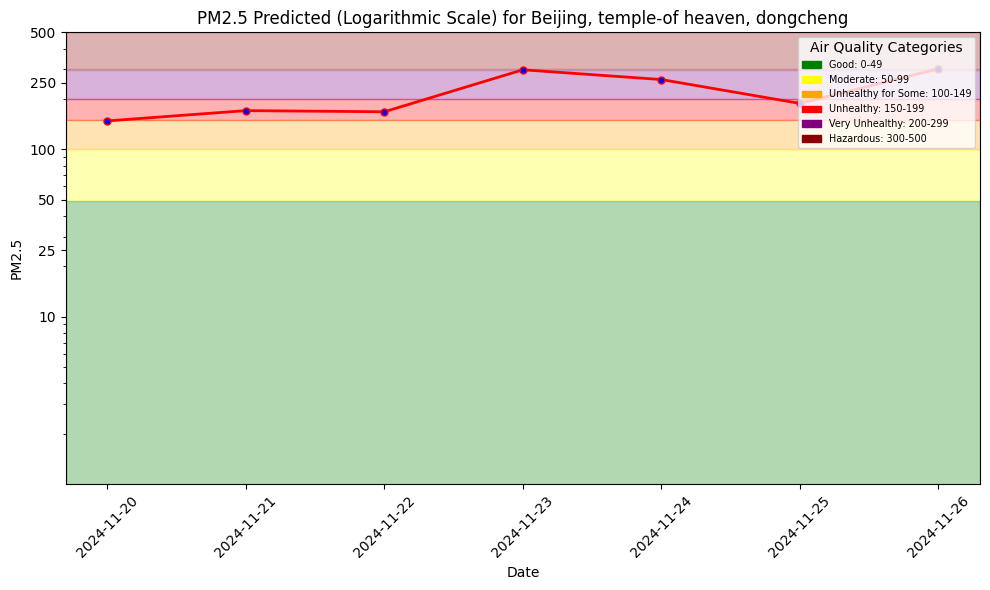

In [18]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, all_batch_data, file_path)
plt.show()

In [21]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','date','days_before_forecast_day'],
    event_time="date"
)

In [23]:
monitor_fg.insert(all_batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/7 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180822/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2aff2646900>, None)

In [25]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25in3day,predicted_pm25,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,2.0,0.0,4.61025,308.659821,Beijing,61.333332,147.857452,1


In [26]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.77s) 


,date,pm25,country,city,street,url,pm25in3day
0,2021-04-15 00:00:00+00:00,144.000000,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,72.000000
1,2015-04-12 00:00:00+00:00,53.000000,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,219.333333
2,2019-05-23 00:00:00+00:00,80.000000,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,53.666667
3,2024-10-30 00:00:00+00:00,172.000000,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,93.000000
4,2021-05-05 00:00:00+00:00,63.000000,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,57.333333
...,...,...,...,...,...,...,...
3959,2024-07-31 00:00:00+00:00,62.000000,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,49.000000
3960,2024-11-22 00:00:00+00:00,167.640320,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,136.956100
3961,2024-11-21 00:00:00+00:00,166.010818,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,98.333336
3962,2024-11-23 00:00:00+00:00,298.733643,China,Beijing,"temple-of heaven, dongcheng",https://api.waqi.info/feed/@447,160.502853


In [27]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-20 00:00:00+00:00,147.857452,147.857452


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

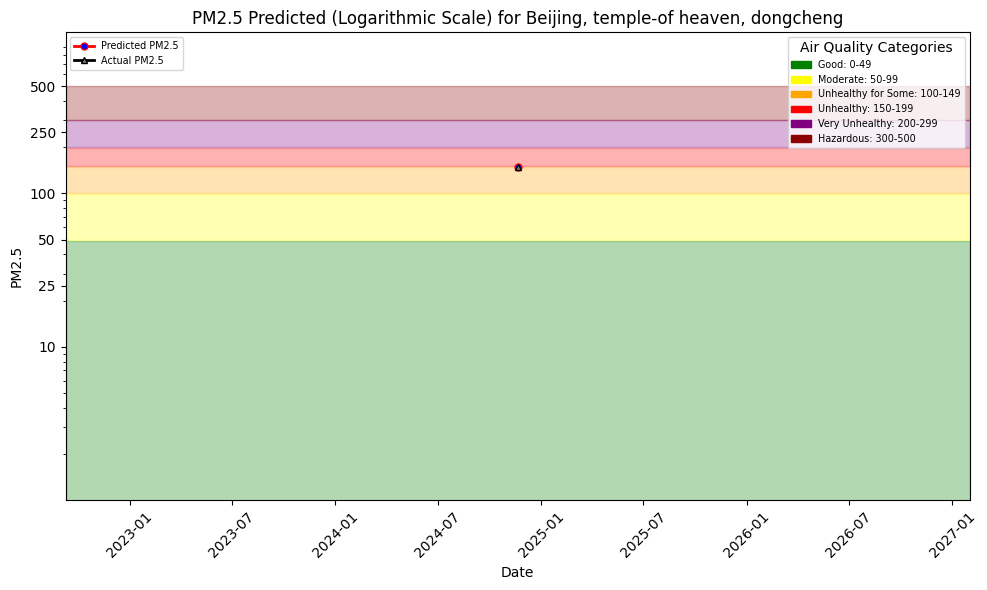

In [28]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---